In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, TreeMakerSchema
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['blue', 'red', 'green', 'violet', 'darkorange', 'black', 'cyan', 'yellow'])

import boost_histogram as bh
import mplhep as hep
plt.style.use(hep.style.CMS) # use CMS style for plotting
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [2]:
from uproot3_methods.classes.TH1 import _histtype, Methods
import boost_histogram as bh
import numpy as np

def bh_to_uproot3(histogram: bh.Histogram):
    r"""
    Write a boost histogram to ROOT file using uproot3 as backend, extended from
      https://github.com/scikit-hep/uproot3-methods/blob/master/uproot3_methods/classes/TH1.py
    Note that uproot(4) will soon officially support boost histogram writing but here we extend the method
      in uproot3_methods as a fast and temporary implementation
    """

    values = histogram.values
    allvalues = histogram.values(flow=True) # flows included, with 2 more bins
    allvariances = histogram.variances(flow=True)
    edges = histogram.axes[0].edges

    class TH1(Methods, list):
        pass

    class TAxis(object):
        def __init__(self, edges):
            self._fNbins = len(edges) - 1
            self._fXmin = edges[0]
            self._fXmax = edges[-1]
            if np.array_equal(edges, np.linspace(self._fXmin, self._fXmax, len(edges), dtype=edges.dtype)):
                self._fXbins = np.array([], dtype=">f8")
            else:
                self._fXbins = edges.astype(">f8")

    out = TH1.__new__(TH1)
    out._fXaxis = TAxis(edges)

    centers = (edges[:-1] + edges[1:]) / 2.0
    out._fEntries = out._fTsumw = out._fTsumw2 = values.sum()
    out._fTsumwx = (values * centers).sum()
    out._fTsumwx2 = (values * centers**2).sum()

    out._fTitle = histogram.label

    out._classname, values = _histtype(values)

    out.extend(allvalues)
    out._fSumw2 = allvariances

    return out

In [3]:
def eval_expr(ak_array, expr, mask=None):
    """A function that can do `eval` to the awkward array, immitating the behavior of `eval` in pandas."""
    
    def get_variable_names(expr, exclude=['awkward', 'ak', 'np', 'numpy', 'math']):
        """Extract variables in the expr"""
        import ast
        root = ast.parse(expr)
        return sorted({node.id for node in ast.walk(root) if isinstance(node, ast.Name) and not node.id.startswith('_')} - set(exclude))

    import numpy as np
    import math
    import awkward as ak
    tmp = {k:ak_array[k] if mask is None else ak_array[k].mask[mask] for k in get_variable_names(expr)}
    tmp.update({'math': math, 'numpy': np, 'np': np, 'awkward': ak, 'ak': ak})
#     print('eval expr: ', expr, '\nvars', get_variable_names(expr))
    return eval(expr, tmp)

In [4]:
import numba as nb
import math

# refer to https://github.com/meng-xiao/HZZ4l-plotter/blob/Moriond-2017/ext/cConstants.cc#L102-L132
@nb.njit
def getDbkgkinConstant(builder, ZZflav_arr, ZZMass_arr): # ZZflav==id1*id2*id3*id4
    for ZZflav, ZZMass in zip(ZZflav_arr, ZZMass_arr):
        par = [
          0.775,
          -0.565,
          70.,
          5.90,
          -0.235,
          130.1,
          13.25,
          -0.33,
          191.04,
          16.05,
          187.47,
          -0.21,
          1700.,
          400.
        ]
        if abs(ZZflav)==121*121 or abs(ZZflav)==121*242 or abs(ZZflav)==242*242:
            par[11]=-0.42 # 4e
        kappa = par[0] \
           + par[1]*math.exp(-math.pow(((ZZMass-par[2])/par[3]), 2)) \
           + par[4]*math.exp(-math.pow(((ZZMass-par[5])/par[6]), 2)) \
           + par[7]*( \
                math.exp(-math.pow(((ZZMass-par[8])/par[9]), 2))*(ZZMass<par[8]) \
                + math.exp(-math.pow(((ZZMass-par[8])/par[10]), 2))*(ZZMass>=par[8]) \
                ) \
           + par[11]*math.exp(-math.pow(((ZZMass-par[12])/par[13]), 2))

        constant = kappa/(1.-kappa)
        builder.real(constant)
    return builder

## Read ROOT

In [5]:
fileset = {
#     'ch': ['/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/HPlusCharm_4FS_M125/ZZ4lAnalysis.root'], # deprecated
#     'hc_3f': ['/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/HPlusCharm_3FS_M125_EvtGenHZZ4l/ZZ4lAnalysis.root'],
#     'hc_4f': ['/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/HPlusCharm_4FS_M125_EvtGenHZZ4l/ZZ4lAnalysis.root'],
#     'hb_4f': ['/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/HPlusBottom_4FS_M125_EvtGenHZZ4l/ZZ4lAnalysis.root'],
#     'hb_5f': ['/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/HPlusBottom_5FS_M125_EvtGenHZZ4l/ZZ4lAnalysis.root'],
    # 'ggh': ['/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/ggH125/ZZ4lAnalysis.root'],
    'qqzz': ['/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/ZZTo4lext1/ZZ4lAnalysis.root', '/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/ZZTo4lext2/ZZ4lAnalysis.root'],
    'ggzz': ['/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/ggTo4e_Contin_MCFM701/ZZ4lAnalysis.root', '/home/pku/licq/cH/zz/samples/cH_MC_2018/AAAOK/ggTo4mu_Contin_MCFM701/ZZ4lAnalysis.root'],
    
    'zx': ['/home/pku/licq/cH/zz/samples/data_2018/ZX_3.root'], ## update to ZX_3 in 220216 for HIG meeting
    
#     ## UL version
#     'ggh_ul': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/ggH125/ZZ4lAnalysis.root'],
#     'ggh_2_ul': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/ggH125_2/ZZ4lAnalysis.root'],
#     'hc_3f_ul': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/HPlusCharm_3FS_M125_EvtGenHZZ4l/ZZ4lAnalysis.root'],
#     'hc_4f_ul': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/HPlusCharm_4FS_M125_EvtGenHZZ4l/ZZ4lAnalysis.root'],
#     'hcjhu_3f_ul': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/HPlusCharm_3FS_M125_JHU_EvtGenHZZ4l/ZZ4lAnalysis.root'],
#     'hcjhu_4f_ul': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/HPlusCharm_4FS_M125_JHU_EvtGenHZZ4l/ZZ4lAnalysis.root'],
    ## ULv3
    # 'ggh_v3_ul': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/ggH125_v3/ZZ4lAnalysis.root'],
    # 'hcjhu_3f_v3_ul': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/HPlusCharm_3FS_M125_JHU_EvtGenHZZ4l_v3/ZZ4lAnalysis.root'],
    'ggh': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/ggH125_v6/ZZ4lAnalysis.root'], ## v6 with SV
    'tth': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/ttH125/ZZ4lAnalysis.root'],
    'vh': [
        '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/ZH125/ZZ4lAnalysis.root',
        '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/WplusH125/ZZ4lAnalysis.root',
        '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/WminusH125/ZZ4lAnalysis.root',
    ],
    'bbh': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/bbH125/ZZ4lAnalysis.root'],
    'vbfh': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/VBFH125/ZZ4lAnalysis.root'],
    # 'hig': [## all higgs. Not used anymore
    #     '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/ggH125_v3/ZZ4lAnalysis.root',
    #     '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/ttH125/ZZ4lAnalysis.root',
    #     '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/ZH125/ZZ4lAnalysis.root',
    #     '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/WplusH125/ZZ4lAnalysis.root',
    #     '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/WminusH125/ZZ4lAnalysis.root',
    #     '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/bbH125/ZZ4lAnalysis.root',
    #     '/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/VBFH125/ZZ4lAnalysis.root',
    # ],
    'hc': ['/home/pku/licq/cH/zz/samples/cH_MC_UL2018/AAAOK/HPlusCharm_3FS_M125_JHU_EvtGenHZZ4l_v6/ZZ4lAnalysis.root'], ## v6 with SV
}
lumi = 59.83*1000

arr = {}
for sam in fileset:
    print('loading..', sam)
    if sam != 'zx':
        arr[sam] = uproot.lazy([file+':ZZTree/candTree' for file in fileset[sam]])
        arr[sam]['gen_sum_weights'] = sum([uproot.open(file+':ZZTree/Counters').to_numpy()[0][39] for file in fileset[sam]])
        arr[sam]['weight'] = eval_expr(arr[sam], 'xsec*overallEventWeight') * lumi / arr[sam].gen_sum_weights
        ## calculate MELA
        arr[sam]['dbkg_kin'] = arr[sam].p_GG_SIG_ghg2_1_ghz1_1_JHUGen / ( arr[sam].p_GG_SIG_ghg2_1_ghz1_1_JHUGen + arr[sam].p_QQB_BKG_MCFM * getDbkgkinConstant(ak.ArrayBuilder(), arr[sam].Z1Flav * arr[sam].Z2Flav, arr[sam].ZZMass).snapshot() )
        arr[sam]['dbkg'] = arr[sam].p_GG_SIG_ghg2_1_ghz1_1_JHUGen*arr[sam].p_m4l_SIG / ( arr[sam].p_GG_SIG_ghg2_1_ghz1_1_JHUGen*arr[sam].p_m4l_SIG + arr[sam].p_QQB_BKG_MCFM*arr[sam].p_m4l_BKG * getDbkgkinConstant(ak.ArrayBuilder(), arr[sam].Z1Flav * arr[sam].Z2Flav, arr[sam].ZZMass).snapshot() )
        # remove outlier weights
        if sam == 'hc':
            cut = (arr[sam].weight > -1e-3) & (arr[sam].weight < 1e-3)
            arr[sam] = arr[sam][cut]
    else:
        arr[sam] = uproot.lazy([file+':candTree' for file in fileset[sam]])
if not hasattr(arr['ggzz'], 'weight_ismod') or not sum(arr['ggzz'].weight_ismod):
    arr['ggzz']['weight'] = arr['ggzz']['weight'] * arr['ggzz'].KFactor_QCD_ggZZ_Nominal * 2 # we lack ggTo2e2mu sample
    arr['ggzz']['weight_ismod'] = True

loading.. qqzz
loading.. ggzz
loading.. zx
loading.. ggh
loading.. tth
loading.. vh
loading.. bbh
loading.. vbfh
loading.. hc


In [6]:
## Load BDT
for sam in fileset:
    print(sam)
    arr[sam]['nJet_loweta'] = ak.fill_none(ak.num(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetPt[abs(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetEta) < 2.5]), 0)
    # if sam in ['qqzz', 'ggzz', 'zx']:
    #     arr[sam]['score0j'] = ak.zeros_like(arr[sam].ZZMass) + 10.
    # else:
    #     arr[sam]['score0j'] = uproot.lazy(f'/home/pku/licq/cH/zz/bdt/hig0218/jet0/output/{sam}.root:Events')['score']
    if sam not in ['ggh', 'hc']:
        if 'SVPt' in arr[sam]:
            sv_tmpl_arr = ak.zeros_like(arr[sam].SVPt) - 1.
        else:
            sv_tmpl_arr = ak.from_numpy(np.zeros([len(arr[sam]), 1], dtype=np.float32)) - 1.
        arr[sam]['SVParticleNetProbCVsL'] = arr[sam]['SVParticleNetProbC'] = arr[sam]['SVParticleNetProbB'] = arr[sam]['SVParticleNetProbCfromB'] = arr[sam]['SVParticleNetProbL'] = sv_tmpl_arr

qqzz


/home/pku/licq/utils/miniconda3/lib/python3.8/site-packages/awkward/highlevel.py:1504: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if element in test:


ggzz
zx
ggh
tth
vh
bbh
vbfh
hc


In [87]:
for sam in fileset:
    arr[sam]['SVParticleNetProbCVsL'] = arr[sam]['SVParticleNetProbC'] / (arr[sam]['SVParticleNetProbC'] + arr[sam]['SVParticleNetProbL'])

In [7]:
def make_plot(title, nbin=50, xmin=70, xmax=170, kc=10, content_arr='arr[sam].ZZMass', weight_arr='arr[sam].weight', xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', 
        ylog=False, custom_bkg=None, custom_sig=None, custom_command=None, store_dir=None):

    import ast
    def exec_then_eval(code):
        block = ast.parse(code, mode='exec')

        # assumes last node is an expression
        last = ast.Expression(block.body.pop().value)

        exec(compile(block, '<string>', mode='exec'))
        return eval(compile(last, '<string>', mode='eval'))

    f, ax = plt.subplots(figsize=(10, 10))
    hep.cms.label(data=True, paper=False, year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'

    plot_bkg_info = { # order is important
        'ggh':  (r'$gg\to H$', 'lightpink'),
        'vbfh':  (r'EW $qqH$', 'thistle'),
        'vh':  (r'$VH$', 'hotpink'),
        'tth':  (r'$t\bar{t}H$', 'violet'),
        'bbh':  (r'$b\bar{b}H$', 'mediumorchid'),
        'qqzz': (r'$q\bar{q}\to ZZ,\,Z\gamma*$', 'lightskyblue'),
        'ggzz': (r'$gg\to ZZ,\,Z\gamma*$', 'royalblue'),
        'zx':   ('Z+X', 'green')
    }
    plot_sig_info = { # only allow one
        'hc':   ('H+c $(\kappa_c=%d)$', 'red'),
    }
    samlist_stack = list(plot_bkg_info.keys())[::-1]
    if custom_bkg is not None:
        samlist_stack = custom_bkg
    if custom_sig is not None:
        plot_sig_info = {k: plot_sig_info[k] for k in custom_sig}

    # get weighted boost histogram
    hist = {}
    for sam in set(plot_sig_info.keys()) | set(samlist_stack):
        print(sam)
        if isinstance(nbin, int):
            axis = bh.axis.Regular(nbin, xmin, xmax)
        else:
            axis = bh.axis.Variable(nbin)
        hist[sam] = bh.Histogram(axis, storage=bh.storage.Weight())
        hist[sam].fill(eval(content_arr), weight=eval(weight_arr)) # replace None value with 1e20
    hist_add = sum([hist[sam] for sam in samlist_stack])

    # make stacked plot
    hep.histplot(
        [hist[sam].view().value for sam in samlist_stack], 
        bins=hist_add.axes[0].edges,
        yerr=[np.sqrt(hist[sam].view().variance) for sam in samlist_stack],
        label=[plot_bkg_info[sam][0] for sam in samlist_stack], color=[plot_bkg_info[sam][1] for sam in samlist_stack], 
        histtype='fill', edgecolor='k', linewidth=1, stack=True,
    )

    # plot signal stat uncertainties
    bkgtot, bkgtot_err = hist_add.view(flow=False).value, np.sqrt(hist_add.view(flow=False).variance)
    ax.fill_between(hist_add.axes[0].edges, (bkgtot-bkgtot_err).tolist()+[0], (bkgtot+bkgtot_err).tolist()+[0], label='BKG stat. unce.', step='post', hatch='///', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

    for samsig in plot_sig_info:
        # plot signal
        hep.histplot(
            hist[samsig].view().value * kc**2,
            bins=hist_add.axes[0].edges,
            yerr=np.sqrt(hist[samsig].view().variance) * kc**2,
            label=plot_sig_info[samsig][0] % kc, color=plot_sig_info[samsig][1], 
        )
#         print('sig', hist[samsig].view().value, 'bkgtot', hist_add.view().value, np.sqrt(2*np.sqrt(hist_add.view().value[0]) / hist[samsig].view().value[0]))
    ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)
    ax.set_xlabel(xlabel, ha='right', x=1.0); ax.set_ylabel(ylabel, ha='right', y=1.0);
    ax.set_xlim(xmin, xmax); ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    if ylog:
        ax.set_yscale('log')
    if custom_command is not None:
        exec(custom_command)
    
    if store_dir is None:
        store_dir = 'plots_0321sv'
    plt.savefig(store_dir + f'/datamc_{title}.jpg')
    plt.savefig(store_dir + f'/datamc_{title}.pdf')


hc
ggh
hc
ggh


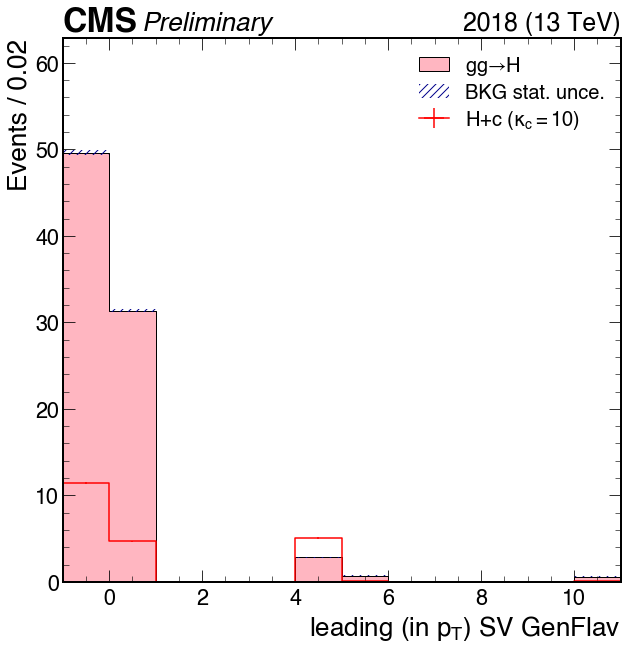

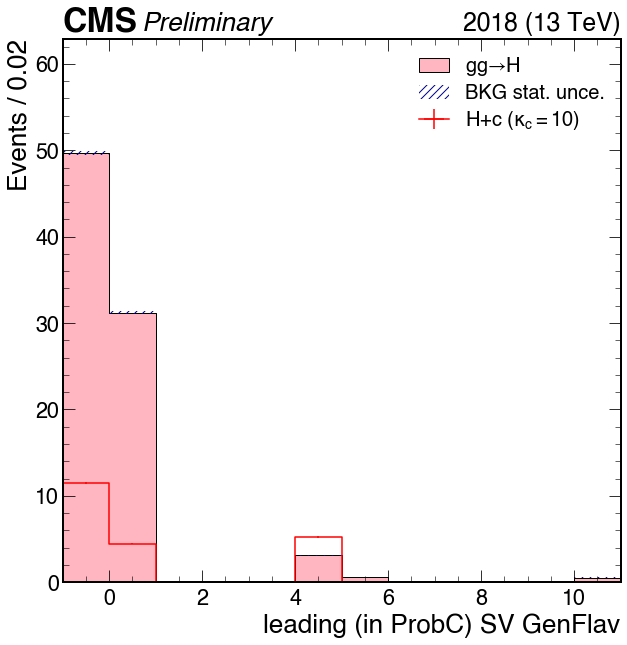

In [92]:
# content_nomass_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVPt)>0]["SVPt"][ak.singletons(ak.argmax(arr[sam].SVPt, axis=-1))][:,0], -1)'
# make_plot(title=f'SVPt_LeadPt_higonly', nbin=40, xmin=0, xmax=200, kc=10, content_arr=f'{content_nomass_arr}[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=f'leading (in $p_T$) SV $p_T$', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggh'], custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")
# content_nomass_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVPt)>0]["SVPt"][ak.singletons(ak.argmax(arr[sam].SVParticleNetProbC, axis=-1))][:,0], -1)'
# make_plot(title=f'SVPt_LeadC_higonly', nbin=40, xmin=0, xmax=200, kc=10, content_arr=f'{content_nomass_arr}[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=f'leading (in ProbC) SV $p_T$', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggh'], custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")
content_nomass_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVPt)>0]["SVGenFlav"][ak.singletons(ak.argmax(arr[sam].SVPt, axis=-1))][:,0], -1)'
make_plot(title=f'SVGenFlav_LeadPt_higonly', nbin=12, xmin=-1, xmax=11, kc=10, content_arr=f'{content_nomass_arr}[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=f'leading (in $p_T$) SV GenFlav', ylabel='Events / 0.02', ylog=False, custom_bkg=['ggh'], custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")
content_nomass_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVPt)>0]["SVGenFlav"][ak.singletons(ak.argmax(arr[sam].SVParticleNetProbC, axis=-1))][:,0], -1)'
make_plot(title=f'SVGenFlav_LeadC_higonly', nbin=12, xmin=-1, xmax=11, kc=10, content_arr=f'{content_nomass_arr}[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=f'leading (in ProbC) SV GenFlav', ylabel='Events / 0.02', ylog=False, custom_bkg=['ggh'], custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")


hc
ggh
hc
ggh


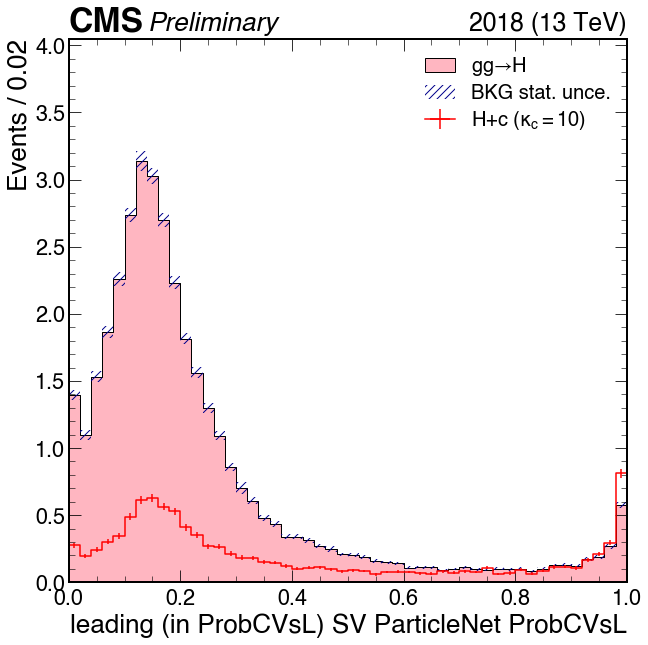

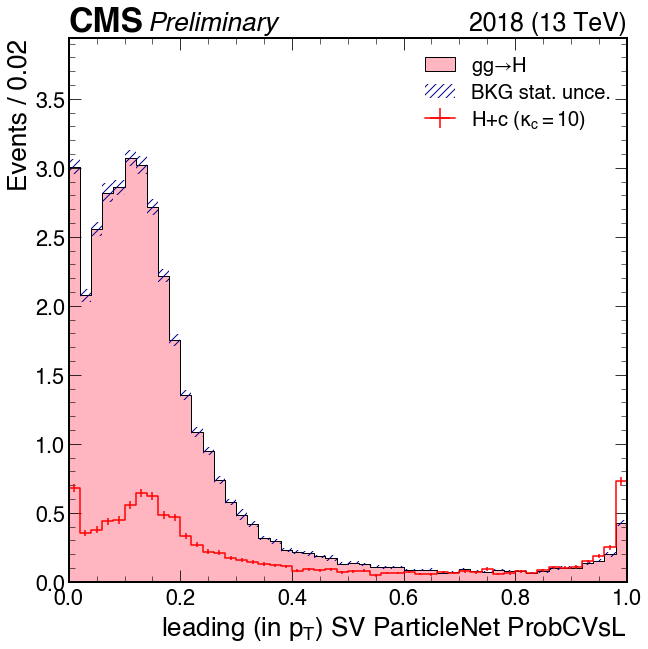

In [91]:
for name in ['ProbCVsL']:
    content_nomass_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVPt)>0]["SVParticleNet{name}"][ak.singletons(ak.argmax(arr[sam].SVParticleNetProbCVsL, axis=-1))][:,0], -1)'
    make_plot(title=f'SVParticleNet{name}_LeadC_higonly', nbin=50, xmin=0, xmax=1, kc=10, content_arr=f'{content_nomass_arr}[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=f'leading (in ProbCVsL) SV ParticleNet {name}', ylabel='Events / 0.02', custom_bkg=['ggh'], custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")
    content_nomass_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVPt)>0]["SVParticleNet{name}"][ak.singletons(ak.argmax(arr[sam].SVPt, axis=-1))][:,0], -1)'
    make_plot(title=f'SVParticleNet{name}_LeadPt_higonly', nbin=50, xmin=0, xmax=1, kc=10, content_arr=f'{content_nomass_arr}[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=f'leading (in $p_T$) SV ParticleNet {name}', ylabel='Events / 0.02', custom_bkg=['ggh'], custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")


hc
ggh
hc
ggh


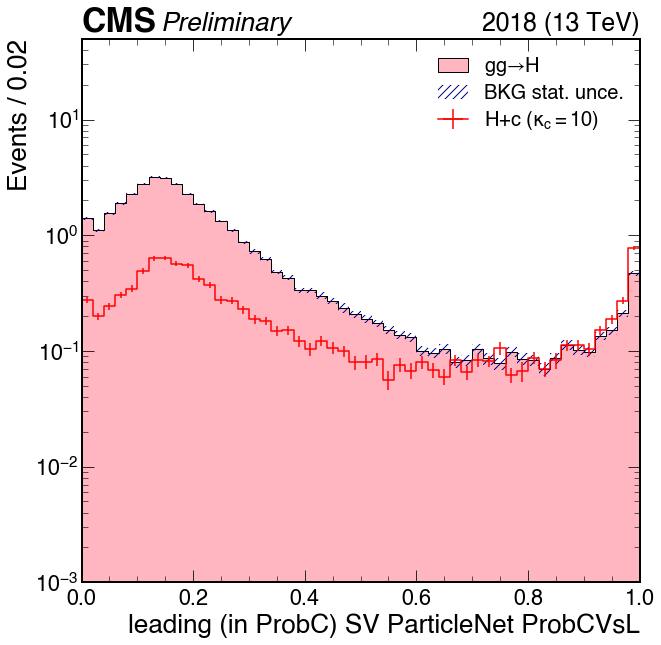

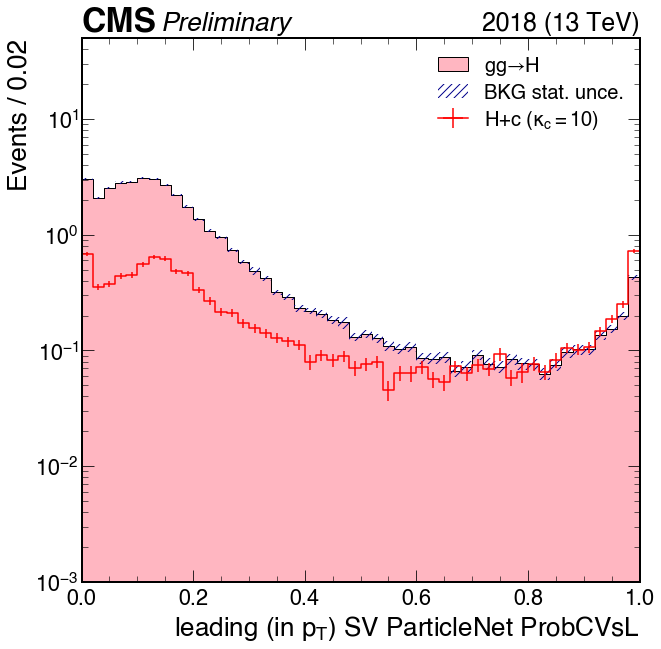

In [88]:
sam = 'ggh'
# for name in ['ProbC', 'ProbB', 'ProbCfromB', 'ProbL']:
for name in ['ProbCVsL']:
    content_nomass_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVPt)>0]["SVParticleNet{name}"][ak.singletons(ak.argmax(arr[sam].SVParticleNetProbC, axis=-1))][:,0], -1)'
    make_plot(title=f'SVParticleNet{name}_LeadC_higonly', nbin=50, xmin=0, xmax=1, kc=10, content_arr=f'{content_nomass_arr}[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=f'leading (in ProbC) SV ParticleNet {name}', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggh'], custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")
    content_nomass_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVPt)>0]["SVParticleNet{name}"][ak.singletons(ak.argmax(arr[sam].SVPt, axis=-1))][:,0], -1)'
    make_plot(title=f'SVParticleNet{name}_LeadPt_higonly', nbin=50, xmin=0, xmax=1, kc=10, content_arr=f'{content_nomass_arr}[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=f'leading (in $p_T$) SV ParticleNet {name}', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggh'], custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")


ggh
hc


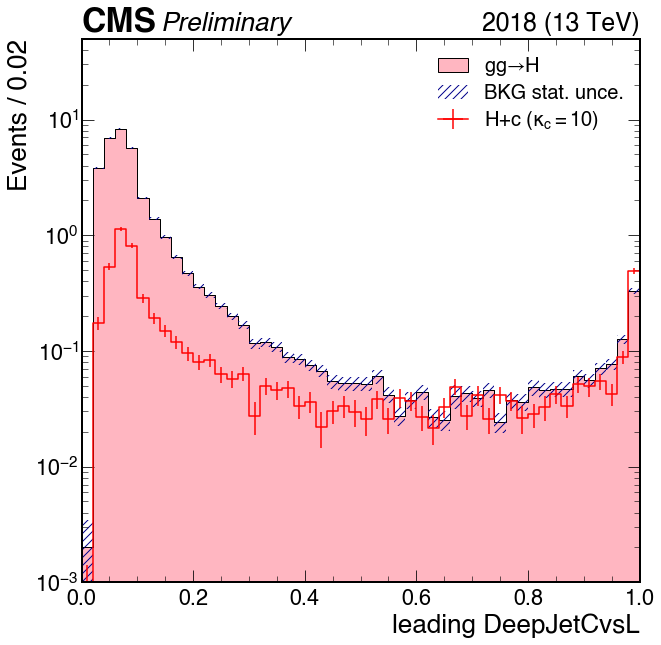

In [12]:
make_plot(title='JetCTaggerVsL_max_higonly', nbin=50, xmin=0, xmax=1, kc=10, content_arr='ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsL, axis=1), -1.)[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=r'leading DeepJetCvsL', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggh'], custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")


hc
qqzz
vh
tth
ggh
ggzz
bbh
vbfh
zx
hc
qqzz
vh
tth
ggh
ggzz
bbh
vbfh
zx


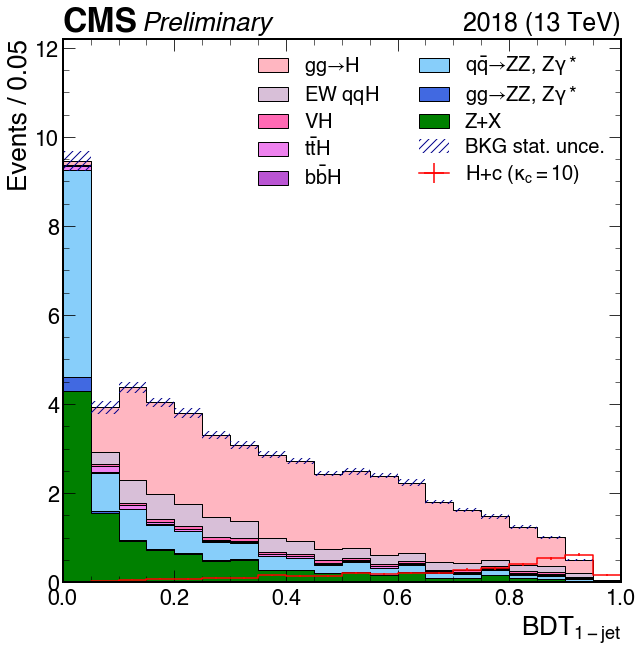

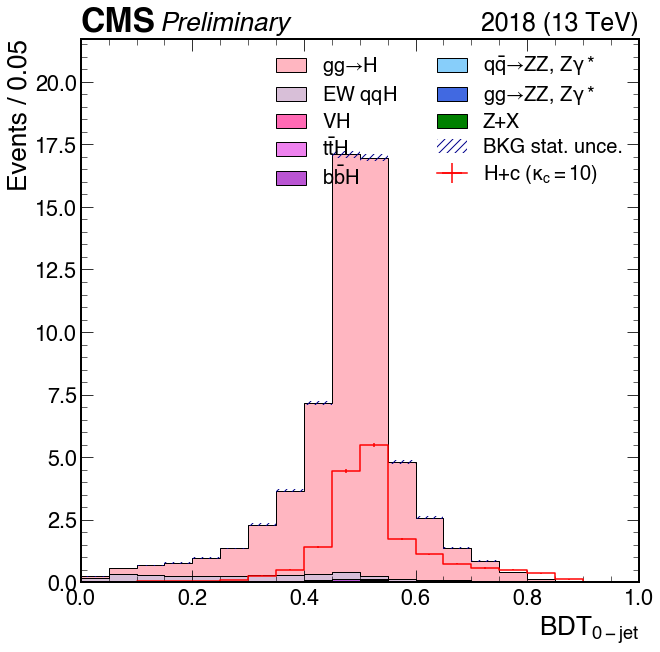

In [72]:
# # inclusive mass
# make_plot(title='ZZMass', nbin=50, xmin=70, xmax=170, kc=10, content_arr='arr[sam].ZZMass', weight_arr='arr[sam].weight', xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV')
# make_plot(title='ZZMass_wide', nbin=282, xmin=72, xmax=1200, kc=10, content_arr='arr[sam].ZZMass', weight_arr='arr[sam].weight', xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 4 GeV', custom_command="ax.set_xscale('log'); ax.set_xticks([80, 100, 200, 300, 400, 500, 700, 1000]); ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())")

# njet OLD DEPRECATED
# varstr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]'
# make_plot(title='nJet', nbin=5, xmin=0, xmax=5, kc=10, content_arr=f'ak.num({varstr}.JetPt)', weight_arr=f'{varstr}.weight', xlabel=r'nJet', ylabel='Events / bin')

# make_plot(title='JetCTaggerVsL_max', nbin=50, xmin=0, xmax=1, kc=10, content_arr='ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsL, axis=1), -1.)[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=r'leading DeepJetCvsL', ylabel='Events / 0.02')
# make_plot(title='JetCTaggerVsL_max_higonly', nbin=50, xmin=0, xmax=1, kc=10, content_arr='ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsL, axis=1), -1.)[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=r'leading DeepJetCvsL', ylabel='Events / 0.02', ylog=True, custom_bkg=['bbh','tth','vh','vbfh','ggh'], custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")
# make_plot(title='JetCTaggerVsB_max', nbin=50, xmin=0, xmax=1, kc=10, content_arr='ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsB, axis=1), -1.)[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=r'leading DeepJetCvsB', ylabel='Events / 0.02')
# make_plot(title='JetCTaggerVsB_max_higonly', nbin=50, xmin=0, xmax=1, kc=10, content_arr='ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsB, axis=1), -1.)[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=r'leading DeepJetCvsB', ylabel='Events / 0.02', ylog=True, custom_bkg=['bbh','tth','vh','vbfh','ggh'], custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")

# njet new
# make_plot(title='nJet', nbin=5, xmin=0, xmax=5, kc=10, content_arr=f'arr[sam].nJet_loweta[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr=f'arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=r'nJet', ylabel='Events / bin')
# make_plot(title='JetCTaggerVsL_max', nbin=50, xmin=0, xmax=1, kc=10, content_arr='ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsL[abs(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetEta) < 2.5], axis=1), -1.)[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=r'leading DeepJetCvsL', ylabel='Events / 0.02')
# make_plot(title='JetCTaggerVsL_max_higonly', nbin=50, xmin=0, xmax=1, kc=10, content_arr='ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsL[abs(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetEta) < 2.5], axis=1), -1.)[(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]', weight_arr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight', xlabel=r'leading DeepJetCvsL', ylabel='Events / 0.02', ylog=True, custom_bkg=['bbh','tth','vh','vbfh','ggh'], custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)")

# varstr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]'
# varstr='arr[sam]'
# make_plot(title='dbkg_kin', nbin=20, xmin=0., xmax=1, kc=10, content_arr=f'{varstr}.dbkg_kin', weight_arr=f'{varstr}.weight', xlabel=r'$D_{bkg}^{kin}$', ylabel='Events / 0.05')
# make_plot(title='dbkg_kin', nbin=dbkg_q, xmin=0., xmax=1, kc=20, content_arr=f'{varstr}.dbkg_kin', weight_arr=f'{varstr}.weight', xlabel=r'$D_{bkg}^{kin}$', ylabel='Events / 0.05')
# make_plot(title='ZZMass', nbin=20, xmin=118, xmax=130, kc=10, content_arr=f'{varstr}.ZZMass', weight_arr=f'{varstr}.weight', xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / bin')

varstr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130) & (arr[sam].ZZMass<130) & (arr[sam].nJet_loweta>0)]'
make_plot(title='bdt_1j', nbin=20, xmin=0., xmax=1., kc=10, content_arr=f'{varstr}.score1j', weight_arr=f'{varstr}.weight', xlabel=r'$BDT_{1-jet}$', ylabel='Events / 0.05')

varstr='arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130) & (arr[sam].ZZMass<130) & (arr[sam].nJet_loweta==0)]'
make_plot(title='bdt_0j', nbin=20, xmin=0., xmax=1., kc=10, content_arr=f'{varstr}.score0j', weight_arr=f'{varstr}.weight', xlabel=r'$BDT_{0-jet}$', ylabel='Events / 0.05')

## Write output

In [7]:
## Write output
import os
basedir='std'
if not os.path.exists(os.path.join('roofit_tpl', basedir)):
    os.makedirs(os.path.join('roofit_tpl', basedir))
for sam in fileset:
    print(sam)
    with uproot.recreate(os.path.join('roofit_tpl', basedir, sam+'.root')) as f:
        if sam != 'hc':
            f['Events'] = {'ZZMass': arr[sam].ZZMass, 'dbkg_kin': arr[sam].dbkg_kin, 'weight': arr[sam].weight}
        else:
            cut = (arr[sam].weight > -1e-3) & (arr[sam].weight < 1e-3)
            f['Events'] = {'ZZMass': arr[sam].ZZMass[cut], 'dbkg_kin': arr[sam].dbkg_kin[cut], 'weight': arr[sam].weight[cut]}


hc


## Write Asimov data

In [11]:
data_dict = {'ZZMass': [], 'dbkg_kin': [], 'weight': []}
def fill(mass, dbkg, weight):
    data_dict['ZZMass'].append(mass)
    data_dict['dbkg_kin'].append(dbkg)
    data_dict['weight'].append(weight)
mass_cat = np.concatenate([ak.to_numpy(arr[sam].ZZMass) for sam in fileset])
dbkg_cat = np.concatenate([ak.to_numpy(arr[sam].dbkg_kin) for sam in fileset])
weight_cat = np.concatenate([ak.to_numpy(arr[sam].weight) for sam in fileset])

## Write 2D template

In [ ]:
rebin_base_sams = ['qqzz', 'ggzz', 'zx']
rebin_base_sams = ['ggh']
dbkg_cat = np.concatenate([ak.to_numpy(arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].dbkg_kin) for sam in rebin_base_sams])
weight_cat = np.concatenate([ak.to_numpy(arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight) for sam in rebin_base_sams])
dbkg_q = weighted_quantile(dbkg_cat, np.linspace(0, 1, 35+1), sample_weight=weight_cat)
dbkg_q[0] = 0.; dbkg_q[-1] = 1.
print(dbkg_q)

mass_axis = bh.axis.Regular(30, 118, 130)
dbkg_axis = bh.axis.Variable(dbkg_q)

result = []
for sam in ['ggh', 'hc', 'qqzz', 'ggzz', 'zx']:
    h2d = bh.Histogram(mass_axis, dbkg_axis, storage=bh.storage.Weight())
    df_cut = arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]
    h2d.fill(df_cut.ZZMass, df_cut.dbkg_kin, weight=df_cut.weight)
    for i in range(h2d.values().shape[0]): # loop over mass dimension
        hv_norm = h2d.values()[i]/sum(h2d.values()[i])
        he_norm = np.sqrt(h2d.variances()[i])/sum(h2d.values()[i])
        result.append([(v, e) for v, e in zip(hv_norm, he_norm)])

with open('unbinned2d/hist_raw.txt', 'w') as f:
    for l in result:
        f.write('  '.join([f'{v:.5E} {e:.5E}' for v, e in l]) + '\n')

## Automating 2D unbinned fit

In [9]:
def single_fit(basedir, selection=None, skip_write_dataset=False, borrow_templ_from_dir=None, hc_norm=1.20, hig_norm=1.063):
    if selection is None:
        selection = "arr[sam].ZZMass > 0"
    import os
    if not os.path.exists(os.path.join('fitspace', basedir)):
        os.makedirs(os.path.join('fitspace', basedir))

    if borrow_templ_from_dir is not None:
        if not os.path.exists(os.path.join('fitspace', basedir)):
            os.makedirs(os.path.join('fitspace', basedir))
        import shutil
        # copy the root file for datacard
        shutil.copy2(os.path.join('fitspace', borrow_templ_from_dir, 'roofit_unbinned2d.root'), os.path.join('fitspace', basedir, 'roofit_unbinned2d.root'))
        # write the datacard
        with open(os.path.join('fitspace', basedir, 'roofit_unbinned2d.txt'), 'w') as f:
            datacard = open(os.path.join('fitspace', borrow_templ_from_dir, 'roofit_unbinned2d_templ.txt')).read()
            f.write(datacard.replace('__HC_NORM__', f'{hc_norm:.3f}').replace('__HIG_NORM__', f'{hig_norm:.3f}')) 
    
    else:
        ## 0. Plot ZZMass distribution to give a feeling
        varstr=f'arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130) & ({selection})]'
        make_plot(title='ZZMass', nbin=20, xmin=118, xmax=130, kc=10, content_arr=f'{varstr}.ZZMass', weight_arr=f'{varstr}.weight', xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / bin', store_dir=os.path.join('fitspace', basedir))

        ## 1. Write plain ROOT file to be loaded into RooDataSet
        if not os.path.exists(os.path.join('roofit_tpl', basedir)):
            os.makedirs(os.path.join('roofit_tpl', basedir))
        if not skip_write_dataset:
            for sam in ['hig', 'hc', 'qqzz', 'ggzz', 'zx']:
                with uproot.recreate(os.path.join('roofit_tpl', basedir, sam+'.root')) as f:
                    if sam == 'hig':
                        events = {'ZZMass': [], 'dbkg_kin': [], 'weight': []}
                        for sam in ['bbh','tth','vh','vbfh','ggh']:
                            arr_sel = arr[sam][eval(selection)]
                            events['ZZMass'].append(arr_sel.ZZMass)
                            events['dbkg_kin'].append(arr_sel.dbkg_kin)
                            events['weight'].append(arr_sel.weight)
                        f['Events'] = {'ZZMass': ak.concatenate(events['ZZMass']), 'dbkg_kin': ak.concatenate(events['dbkg_kin']), 'weight': ak.concatenate(events['weight'])}
                    else:
                        arr_sel = arr[sam][eval(selection)]
                        if sam == 'hc':
                            arr_sel = arr_sel[(arr_sel.weight > -1e-3) & (arr_sel.weight < 1e-3)]
                        f['Events'] = {'ZZMass': arr_sel.ZZMass, 'dbkg_kin': arr_sel.dbkg_kin, 'weight': arr_sel.weight}
        
        ## 2. Get ananlytical shape
        import subprocess
        out = subprocess.check_output(f"bash fitspace/launch_prefit_1dparams.sh {basedir}", shell=True).decode().splitlines()
        for line in out:
            if line.startswith(">>TAG>>"):
                rate = line.replace(">>TAG>>", "")
                break
        print(rate)

        datacard = '''imax 1 channels
jmax 4 backgrounds
kmax * systematics
-------------------------------
shapes * * roofit_unbinned2d.root w:$PROCESS
-------------------------------
bin             A
observation    -1
-------------------------------
bin             A      A    A    A     A
process         0      1    2    3    4
process         hc     hig  qqzz ggzz zx
rate           %s
-------------------------------
hc_norm    lnN  __HC_NORM__   -    -    -    -
hig_norm   lnN  -      __HIG_NORM__ -   -    -
qqzz_norm  lnN  -      -   1.056 -    -
ggzz_norm  lnN  -      -    -    1.080 -
zx_norm    lnN  -      -    -    -    1.170
''' % (rate)

        with open(os.path.join('fitspace', basedir, 'roofit_unbinned2d_templ.txt'), 'w') as f:
            f.write(datacard)
        with open(os.path.join('fitspace', basedir, 'roofit_unbinned2d.txt'), 'w') as f:
            f.write(datacard.replace('__HC_NORM__', f'{hc_norm:.3f}').replace('__HIG_NORM__', f'{hig_norm:.3f}')) 

        ## Write 2D template

        # weighted quantile
        def weighted_quantile(values, quantiles, sample_weight=None, 
                            values_sorted=False, old_style=False):
            values = np.array(values)
            quantiles = np.array(quantiles)
            if sample_weight is None:
                sample_weight = np.ones(len(values))
            sample_weight = np.array(sample_weight)
            assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
                'quantiles should be in [0, 1]'

            if not values_sorted:
                sorter = np.argsort(values)
                values = values[sorter]
                sample_weight = sample_weight[sorter]

            weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
            if old_style:
                # To be convenient with numpy.percentile
                weighted_quantiles -= weighted_quantiles[0]
                weighted_quantiles /= weighted_quantiles[-1]
            else:
                weighted_quantiles /= np.sum(sample_weight)
            return np.interp(quantiles, weighted_quantiles, values)
            
        rebin_base_sams = ['bbh','tth','vh','vbfh','ggh']
        dbkg_cat = np.concatenate([ak.to_numpy(arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].dbkg_kin) for sam in rebin_base_sams])
        weight_cat = np.concatenate([ak.to_numpy(arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)].weight) for sam in rebin_base_sams])
        dbkg_q = weighted_quantile(dbkg_cat, np.linspace(0, 1, 35+1), sample_weight=weight_cat)
        dbkg_q[0] = 0.; dbkg_q[-1] = 1.
        print(dbkg_q)

        mass_axis = bh.axis.Regular(30, 118, 130)
        dbkg_axis = bh.axis.Variable(dbkg_q)

        result = []
        for sam in ['hig', 'hc', 'qqzz', 'ggzz', 'zx']:
            h2d = bh.Histogram(mass_axis, dbkg_axis, storage=bh.storage.Weight())
            if sam != 'hig':
                df_cut = arr[sam][(arr[sam].ZZMass>118) & (arr[sam].ZZMass<130)]
                h2d.fill(df_cut.ZZMass, df_cut.dbkg_kin, weight=df_cut.weight)
            else:
                for s in ['bbh','tth','vh','vbfh','ggh']:
                    df_cut = arr[s][(arr[s].ZZMass>118) & (arr[s].ZZMass<130)]
                    h2d.fill(df_cut.ZZMass, df_cut.dbkg_kin, weight=df_cut.weight)
            for i in range(h2d.values().shape[0]): # loop over mass dimension
                hv_norm = h2d.values()[i]/sum(h2d.values()[i])
                he_norm = np.sqrt(h2d.variances()[i])/sum(h2d.values()[i])
                hv_norm = np.maximum(hv_norm, 1e-6)
                he_norm = np.minimum(np.maximum(he_norm, 1e-6), hv_norm)
                result.append([(v, e) for v, e in zip(hv_norm, he_norm)])

        with open(os.path.join('fitspace', basedir, 'hist_raw.txt'), 'w') as f:
            for l in result:
                f.write('  '.join([f'{v:.5E} {e:.5E}' for v, e in l]) + '\n')
        import subprocess
        rate_input = ','.join(rate.split())
        out = subprocess.check_output(f"bash fitspace/launch_prefit_2dtempl.sh {basedir} {rate_input}", shell=True).decode().splitlines()

    # end of making new template

    ## Fit 2D shape
    import subprocess
    out = subprocess.check_output(f"bash fitspace/launch_fit.sh {basedir}", shell=True).decode().splitlines()

    for il, line in enumerate(out):
        if line.startswith(" -- AsymptoticLimits ( CLs ) --"):
            print(out[il:])
        if line.startswith("Expected 50.0%"):
            import re
            limit = float(re.findall('r < (\S+)', line)[0])
            return limit

def get_limit(basedir):
    with open(os.path.join('fitspace', basedir, 'fit.log')) as f:
        lines = f.readlines()
    for il, line in enumerate(lines):
        if line.startswith("Expected 50.0%"):
            import re
            limit = float(re.findall('r < (\S+)', line)[0])
            return limit

hc
qqzz
vh
tth
ggh
ggzz
bbh
vbfh
zx


Info in <TCanvas::Print>: png file pdfm4l_shape.png has been created


0.21305  95.528  33.6402  1.69503  17.0712
[0.         0.89765693 0.9318763  0.94787359 0.95746354 0.9641436
 0.96909631 0.97297419 0.97604786 0.97864937 0.98073344 0.98256052
 0.98414097 0.98551746 0.98672659 0.98783137 0.98882823 0.98975057
 0.99060288 0.99141046 0.99215074 0.99282377 0.99344047 0.99400791
 0.99456557 0.99510481 0.99561303 0.99610952 0.99658247 0.9970273
 0.99746499 0.99787043 0.99827318 0.99867413 0.9991272  1.        ]


Info in <TCanvas::Print>: png file datahist.png has been created


[' -- AsymptoticLimits ( CLs ) --', 'Observed Limit: r < 176.4752', 'Expected  2.5%: r < 91.8633', 'Expected 16.0%: r < 123.8805', 'Expected 50.0%: r < 175.5000', 'Expected 84.0%: r < 254.5492', 'Expected 97.5%: r < 361.4001', '', 'Done in 0.01 min (cpu), 0.01 min (real)']


175.5

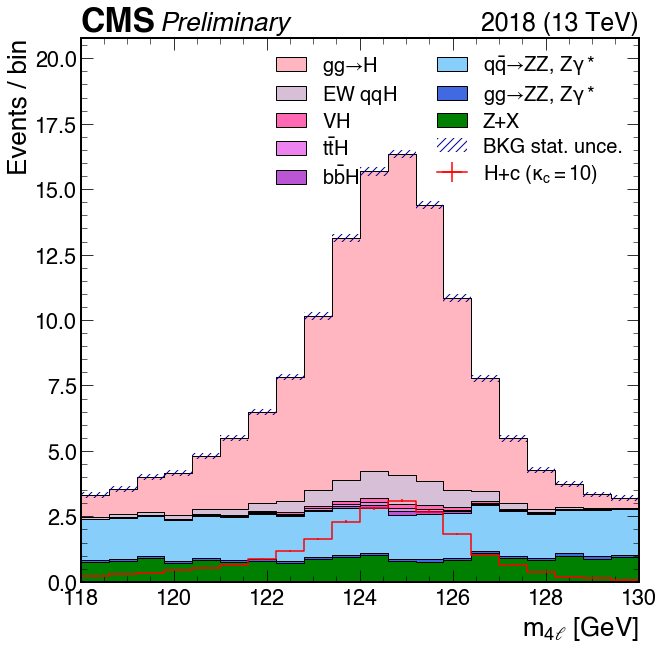

In [73]:
# single_fit('hig0214')
single_fit('hig0214_hignorm1.2', hig_norm=1.2)
# # single_fit('hig0214_0', 'arr[sam].ZZMass > 0')

In [69]:
# [get_limit(f'hig0214_ctag{ctag_thres:.3f}') for ctag_thres in np.arange(0.00, 0.11, 0.01)]
# [get_limit(f'hig0214_ctag{ctag_thres:.3f}_hignorm1.2') for ctag_thres in np.arange(0.00, 0.11, 0.01)]
# [get_limit(f'hig0218_bdt1j{bdt1j_thres:.2f}_hignorm1.2') for bdt1j_thres in np.arange(0.6, 0.82, 0.02)]
# np.sqrt(np.array([get_limit(f'hig0218_bdt0j{bdt0j_thres:.2f}_hignorm1.2') for bdt0j_thres in np.arange(0.0, 0.8, 0.05)]))
np.sqrt(get_limit(f'hig0218_ctag0.100_hignorm1.2'))
# np.sqrt(get_limit(f'hig0218_bdt1j0.70_hignorm1.2'))

18.907670401189037

In [132]:
np.sqrt(np.array([get_limit(f'hig0214_ctag{ctag_thres:.3f}_hignorm1.2') for ctag_thres in x]))

array([19.27433527, 19.27433527, 19.77371993, 19.49358869, 18.9076704 ,
       18.89444363, 19.27433527, 18.81488772, 18.92088793, 19.23538406,
       19.28730152])

hc
qqzz
vh
tth
ggh
ggzz
bbh
vbfh
zx


Info in <TCanvas::Print>: png file pdfm4l_shape.png has been created


0.0391994  33.6051  9.70397  0.562687  10.9195
[0.         0.89765693 0.9318763  0.94787359 0.95746354 0.9641436
 0.96909631 0.97297419 0.97604786 0.97864937 0.98073344 0.98256052
 0.98414097 0.98551746 0.98672659 0.98783137 0.98882823 0.98975057
 0.99060288 0.99141046 0.99215074 0.99282377 0.99344047 0.99400791
 0.99456557 0.99510481 0.99561303 0.99610952 0.99658247 0.9970273
 0.99746499 0.99787043 0.99827318 0.99867413 0.9991272  1.        ]


Info in <TCanvas::Print>: png file datahist.png has been created


[' -- AsymptoticLimits ( CLs ) --', 'Observed Limit: r < 477.1131', 'Expected  2.5%: r < 241.0195', 'Expected 16.0%: r < 327.2622', 'Expected 50.0%: r < 471.0000', 'Expected 84.0%: r < 698.1686', 'Expected 97.5%: r < 1016.4583', '', 'Done in 0.05 min (cpu), 0.05 min (real)']


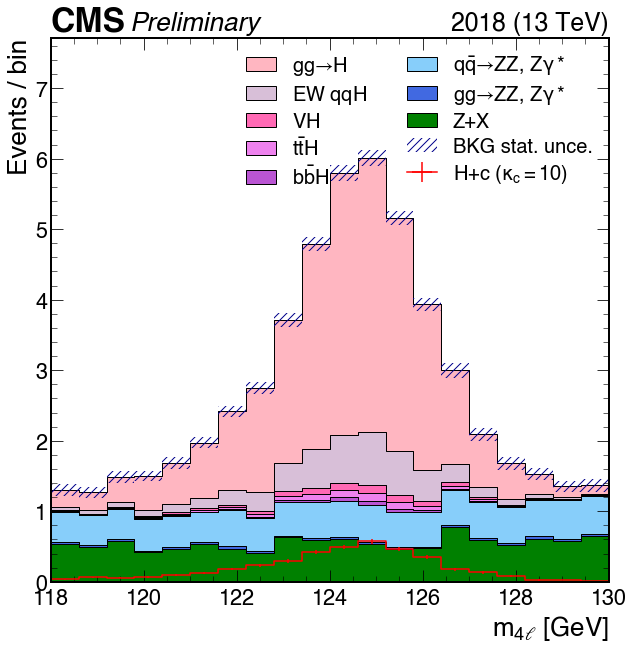

In [55]:
for ctag_thres in [0]:
    ctag_sel = f"ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsL[abs(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetEta) < 2.5], axis=1), -1.) > {ctag_thres:.3f}"
    single_fit(f'hig0218_ctag{ctag_thres:.3f}_hignorm1.2', ctag_sel, hig_norm=1.2)

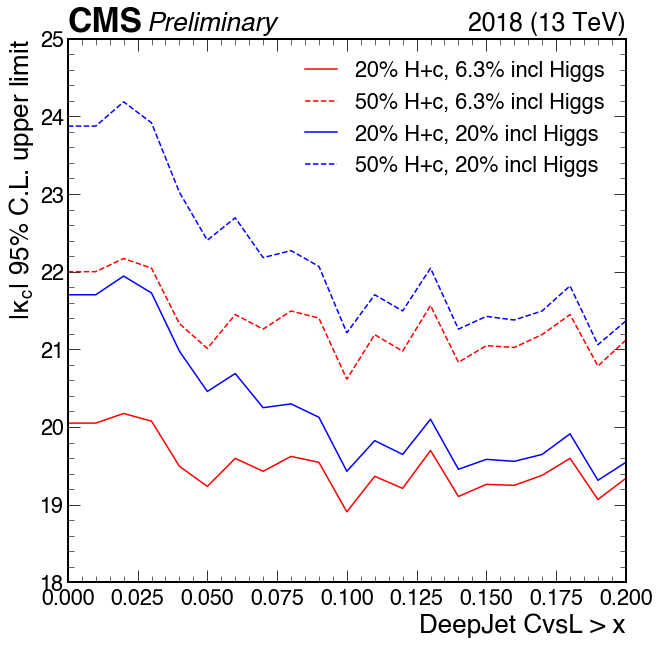

In [41]:
# for ctag_thres in np.arange(0.00, 0.1, 0.01):
#     ctag_sel = f"ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsL, axis=1), -1.) > {ctag_thres:.3f}"
#     single_fit(f'hig0214_ctag{ctag_thres:.3f}', ctag_sel)
#     single_fit(f'hig0214_ctag{ctag_thres:.3f}_hignorm1.2', ctag_sel, borrow_templ_from_dir=f'hig0214_ctag{ctag_thres:.3f}', hig_norm=1.2)
#     single_fit(f'hig0214_ctag{ctag_thres:.3f}_hcnorm1.5', ctag_sel, borrow_templ_from_dir=f'hig0214_ctag{ctag_thres:.3f}', hc_norm=1.5)
#     single_fit(f'hig0214_ctag{ctag_thres:.3f}_hcnorm1.5_hignorm1.2', ctag_sel, borrow_templ_from_dir=f'hig0214_ctag{ctag_thres:.3f}', hc_norm=1.5, hig_norm=1.2)

# # 0218 for using the jets with eta<2.5
# for ctag_thres in np.arange(0.10, 0.21, 0.01):
#     ctag_sel = f"ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsL[abs(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetEta) < 2.5], axis=1), -1.) > {ctag_thres:.3f}"
#     single_fit(f'hig0218_ctag{ctag_thres:.3f}', ctag_sel)
#     single_fit(f'hig0218_ctag{ctag_thres:.3f}_hignorm1.2', ctag_sel, borrow_templ_from_dir=f'hig0218_ctag{ctag_thres:.3f}', hig_norm=1.2)
#     single_fit(f'hig0218_ctag{ctag_thres:.3f}_hcnorm1.5', ctag_sel, borrow_templ_from_dir=f'hig0218_ctag{ctag_thres:.3f}', hc_norm=1.5)
#     single_fit(f'hig0218_ctag{ctag_thres:.3f}_hcnorm1.5_hignorm1.2', ctag_sel, borrow_templ_from_dir=f'hig0218_ctag{ctag_thres:.3f}', hc_norm=1.5, hig_norm=1.2)

# make plots
f, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(data=True, paper=False, year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'

x = np.arange(0.00, 0.21, 0.01)
ax.plot(x, np.sqrt(np.array([get_limit(f'hig0218_ctag{ctag_thres:.3f}') for ctag_thres in x])), color='red', label='20% H+c, 6.3% incl Higgs')
ax.plot(x, np.sqrt(np.array([get_limit(f'hig0218_ctag{ctag_thres:.3f}_hcnorm1.5') for ctag_thres in x])), color='red', ls='--', label='50% H+c, 6.3% incl Higgs')
ax.plot(x, np.sqrt(np.array([get_limit(f'hig0218_ctag{ctag_thres:.3f}_hignorm1.2') for ctag_thres in x])), color='blue', label='20% H+c, 20% incl Higgs')
ax.plot(x, np.sqrt(np.array([get_limit(f'hig0218_ctag{ctag_thres:.3f}_hcnorm1.5_hignorm1.2') for ctag_thres in x])), color='blue', ls='--', label='50% H+c, 20% incl Higgs')
ax.legend()
ax.set_ylim(18, 25); ax.set_xlim(0, 0.2)
ax.set_xlabel('DeepJet CvsL > x', ha='right', x=1.0); ax.set_ylabel(r'$|\kappa_c|$ 95% C.L. upper limit', ha='right', y=1.0);
plt.savefig('plots/deepjet_scan.pdf')

hc
qqzz
vh
tth
ggh
ggzz
bbh
vbfh
zx


Info in <TCanvas::Print>: png file pdfm4l_shape.png has been created


0.0391994  33.6051  9.70397  0.562687  10.9195
[0.         0.89765693 0.9318763  0.94787359 0.95746354 0.9641436
 0.96909631 0.97297419 0.97604786 0.97864937 0.98073344 0.98256052
 0.98414097 0.98551746 0.98672659 0.98783137 0.98882823 0.98975057
 0.99060288 0.99141046 0.99215074 0.99282377 0.99344047 0.99400791
 0.99456557 0.99510481 0.99561303 0.99610952 0.99658247 0.9970273
 0.99746499 0.99787043 0.99827318 0.99867413 0.9991272  1.        ]


Info in <TCanvas::Print>: png file datahist.png has been created


[' -- AsymptoticLimits ( CLs ) --', 'Observed Limit: r < 477.1131', 'Expected  2.5%: r < 241.0195', 'Expected 16.0%: r < 327.2622', 'Expected 50.0%: r < 471.0000', 'Expected 84.0%: r < 698.1686', 'Expected 97.5%: r < 1016.4583', '', 'Done in 0.05 min (cpu), 0.05 min (real)']


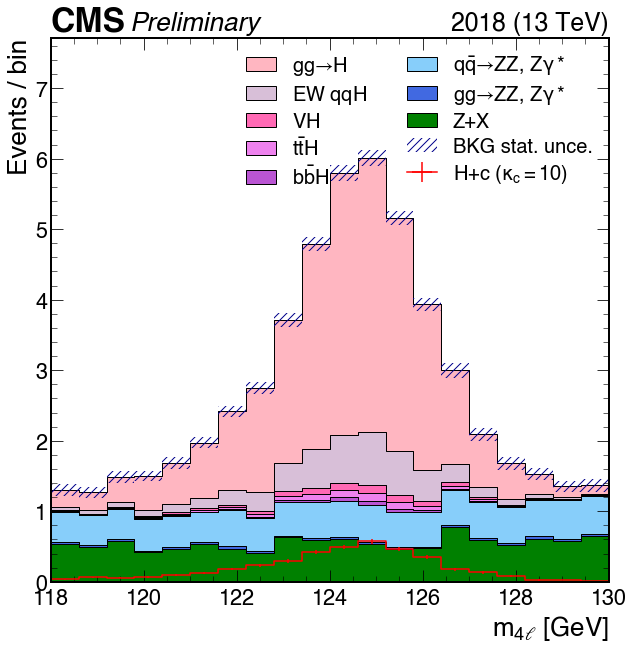

In [57]:
# for bdt1j_thres in np.arange(0.60, 0.82, 0.02):
#     bdt1j_sel = f"((arr[sam].nJet_loweta > 0) & (arr[sam].score1j > {bdt1j_thres}))"
#     single_fit(f'hig0218_bdt1j{bdt1j_thres:.2f}_hignorm1.2', bdt1j_sel, hig_norm=1.2)

# for bdt1j_lo, bdt1j_hi in [(0.70, 1.00), (0.40, 0.70), (0.00, 0.40)]:
#     bdt1j_sel = f"((arr[sam].nJet_loweta > 0) & (arr[sam].score1j >= {bdt1j_lo}) & (arr[sam].score1j < {bdt1j_hi}))"
#     single_fit(f'hig0218_bdt1j{bdt1j_lo:.2f}-{bdt1j_hi:.2f}_hignorm1.2', bdt1j_sel, hig_norm=1.2)

In [52]:
# # for bdt0j_lo, bdt0j_hi in [(0.40, 1.00)]:
# # for bdt0j_lo, bdt0j_hi in [(0.00, 0.40)]:
# for bdt0j_lo in np.arange(0.0, 0.3, 0.05):
#     bdt0j_sel = f"((arr[sam].nJet_loweta == 0) & (arr[sam].score0j >= {bdt0j_lo}))"
#     single_fit(f'hig0218_bdt0j{bdt0j_lo:.2f}_hignorm1.2', bdt0j_sel, hig_norm=1.2)

In [55]:
sam = 'zx'
# ak.singletons(arr[sam].SVParticleNetProbC)
ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].SVParticleNetProbC)>0].SVParticleNetProbC, axis=1), -1) >= 0.0

<Array [True, True, True, ... True, True, True] type='48155 * bool'>

In [64]:
np.arange(0.0, 0.3, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25])

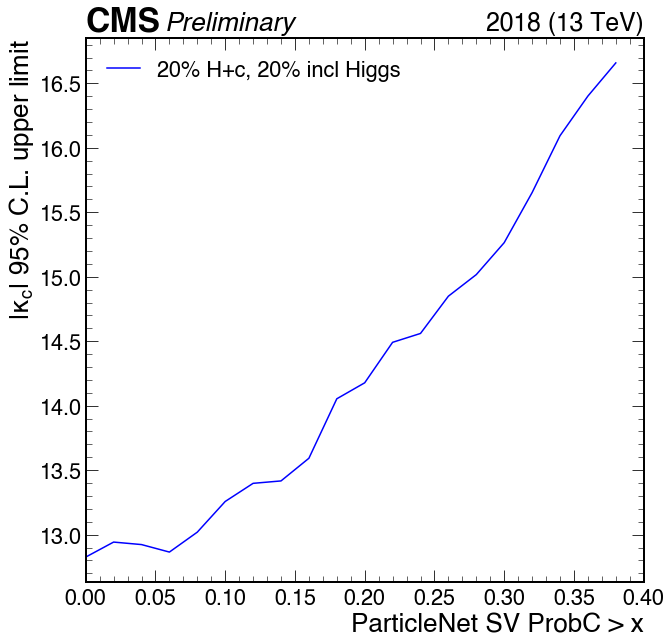

In [14]:
# # # single_fit(f'hig0321sv_bdt0j_hignorm1.2', '(arr[sam].nJet_loweta == 0)', hig_norm=1.2)

# for svpnet_thres in np.arange(0., 0.4, 0.02):
#     # svpnet_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVParticleNetProbC)>0].SVParticleNetProbC[ak.singletons(ak.argmax(arr[sam].SVParticleNetProbC, axis=-1))][:,0], -1)'
#     svpnet_sel = f'ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].SVParticleNetProbC)>0].SVParticleNetProbC, axis=1), -1) >= {svpnet_thres}'
#     single_fit(f'hig0321sv_bdt0j_svpnet{svpnet_thres:.2f}_hignorm1.2', f'(arr[sam].nJet_loweta == 0) & ({svpnet_sel})', hig_norm=1.2)

# make plots
f, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(data=True, paper=False, year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'
x = np.arange(0., 0.4, 0.02)
ax.plot(x, np.sqrt(np.array([get_limit(f'hig0321sv_bdt0j_svpnet{ctag_thres:.2f}_hignorm1.2') for ctag_thres in x])), color='blue', label='20% H+c, 20% incl Higgs')
ax.legend()
ax.set_xlim(0, 0.4)
ax.set_xlabel('ParticleNet SV ProbC > x', ha='right', x=1.0); ax.set_ylabel(r'$|\kappa_c|$ 95% C.L. upper limit', ha='right', y=1.0);
# plt.savefig('plots/deepjet_scan.pdf')

# # for svpnet_thres in np.arange(0.02, 0.2, 0.02):
# for svpnet_thres in np.arange(0.0, 0.5, 0.05):
#     # svpnet_arr = f'ak.fill_none(arr[sam].mask[ak.num(arr[sam].SVParticleNetProbC)>0].SVParticleNetProbC[ak.singletons(ak.argmax(arr[sam].SVParticleNetProbC, axis=-1))][:,0], -1)'
#     svpnet_sel = f'ak.fill_none(ak.max(arr[sam].mask[ak.num(arr[sam].SVParticleNetProbCVsL)>0].SVParticleNetProbCVsL, axis=1), -1) >= {svpnet_thres}'
#     single_fit(f'hig0321sv_bdt0j_svpnetcvl{svpnet_thres:.2f}_hignorm1.2', f'(arr[sam].nJet_loweta == 0) & ({svpnet_sel})', hig_norm=1.2)

# # make plots
# f, ax = plt.subplots(figsize=(10, 10))
# hep.cms.label(data=True, paper=False, year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'

# x = np.arange(0., 0.5, 0.05)
# ax.plot(x, np.sqrt(np.array([get_limit(f'hig0321sv_bdt0j_svpnetcvl{ctag_thres:.2f}_hignorm1.2') for ctag_thres in x])), color='blue', label='20% H+c, 20% incl Higgs')
# ax.legend()
# ax.set_xlim(0, 0.5)
# ax.set_xlabel('ParticleNet SV CvsL > x', ha='right', x=1.0); ax.set_ylabel(r'$|\kappa_c|$ 95% C.L. upper limit', ha='right', y=1.0);
# # plt.savefig('plots/deepjet_scan.pdf')

## ROC curve: SV PNet

In [76]:
import sklearn.metrics as m

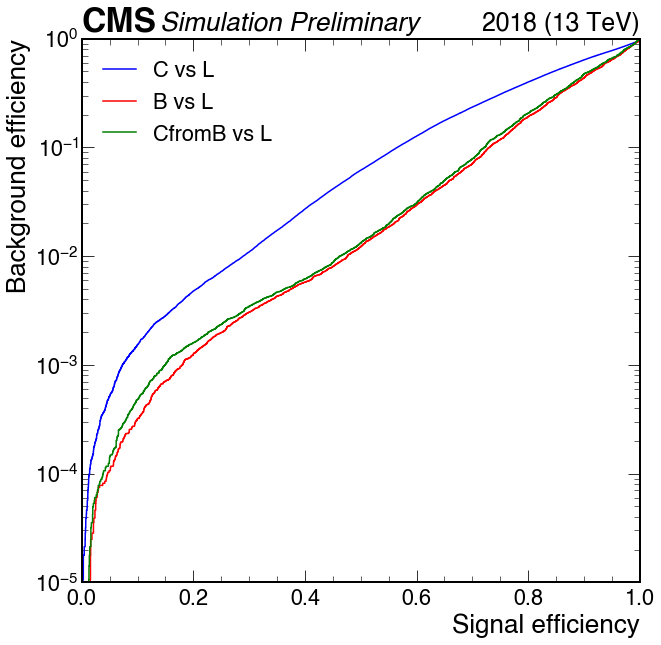

In [102]:
f, ax = plt.subplots()
hep.cms.label(data=False, year=2018, ax=ax, fontname='sans-serif')

sam = 'hc'
sel = (arr[sam].SVPt >= 0.) & (arr[sam].SVPt < 10.)
idx_l = ak.flatten(arr[sam].SVGenFlav[sel]) == 0
idx_c = ak.flatten(arr[sam].SVGenFlav[sel]) == 4
idx_cfb = ak.flatten(arr[sam].SVGenFlav[sel]) == 10
idx_b = ak.flatten(arr[sam].SVGenFlav[sel]) == 5

for idx_sig, score, label in zip(
    [idx_c, idx_b, idx_cfb],
    [
        arr[sam].SVParticleNetProbC/(arr[sam].SVParticleNetProbC + arr[sam].SVParticleNetProbL),
        arr[sam].SVParticleNetProbB/(arr[sam].SVParticleNetProbB + arr[sam].SVParticleNetProbL),
        arr[sam].SVParticleNetProbCfromB/(arr[sam].SVParticleNetProbCfromB + arr[sam].SVParticleNetProbL)
    ],
    ['C vs L', 'B vs L', 'CfromB vs L'],
):
    idx = (idx_l) | (idx_sig)
    y_true = idx_sig[idx]
    y_score = ak.flatten(score[sel])[idx]
    fpr, tpr, _thres = m.roc_curve(y_true, y_score)
    ax.plot(tpr, fpr, label=label)

ax.legend(loc='upper left')
ax.set_yscale('log'); ax.set_xlim(0, 1); ax.set_ylim(1e-5, 1)
ax.set_xlabel('Signal efficiency', ha='right', x=1.0); ax.set_ylabel('Background efficiency', ha='right', y=1.0);
# plt.savefig('plots_0321sv/sv_roc_hc_0_10.pdf')

## Make BDT inputs

In [24]:
# ## more jet variables for BDT training
# basevars = [
#     'ZZMass', 'ZZPt', 'ZZEta', 'ZZPhi', 'dbkg_kin', 'weight',
# ]
# jetvars = [
#     'JetPt',
#     'JetEta',
#     'JetPhi',
#     'JetMass',
#     # 'JetEnergy', # no jet energy...
#     'JetQGLikelihood',
#     'JetPUValue',
#     'JetCTaggerVsL',
#     'JetCTaggerVsB',
# ]
# # v3: add SV
# svvars = [
#     "SVPhi",
#     "SVEta",
#     "SVMass",
#     "SVEnergy",
#     "SVPt",
#     "SVNTracks",
#     "SVNormChi2",
#     "SVDxy",
#     "SVDxySig",
#     "SVD3d",
#     "SVD3dSig",
#     "SVCosThetaSVPV",
# ]
# _samlist = ['bbh','tth','vh','vbfh','ggh','hc','ggzz','qqzz','zx']

# bdtarr = {}
# for sam in _samlist:
#     arr_sel = arr[sam]
#     if sam == 'hc':
#         arr_sel = arr_sel[(arr_sel.weight > -1e-3) & (arr_sel.weight < 1e-3)]

#     bdtarr[sam] = {}
#     if sam != 'zx':
#         bdtarr[sam]['event'] = arr[sam]['EventNumber']
#     else:
#         bdtarr[sam]['event'] = ak.argsort(ak.zeros_like(arr_sel.ZZMass)) # [0,1,2,3,...]
#     for var in basevars:
#         bdtarr[sam][var] = arr_sel[var]

#     ## === Jets ===
#     bdtarr[sam]['nJet'] = ak.num(arr_sel.JetPt)
#     for i in [0, 1]:
#         for var in jetvars:
#             bdtarr[sam][f'Jet{i}{var[3:]}'] = arr_sel.mask[bdtarr[sam]['nJet'] > i][var][:, i]
#         bdtarr[sam][f'Jet{i}DeltaRZZ'] = np.hypot(bdtarr[sam][f'Jet{i}Eta'] - bdtarr[sam]['ZZEta'], bdtarr[sam][f'Jet{i}Phi'] - bdtarr[sam]['ZZPhi'])
#         bdtarr[sam][f'Jet{i}DeltaEtaZZ'] = np.abs(bdtarr[sam][f'Jet{i}Eta'] - bdtarr[sam]['ZZEta'])
#         bdtarr[sam][f'Jet{i}DeltaPhiZZ'] = np.abs(bdtarr[sam][f'Jet{i}Phi'] - bdtarr[sam]['ZZPhi'])
#     # max c-tagging score
#     idx_max = ak.singletons(ak.argmax(arr_sel.JetCTaggerVsL, axis=-1))
#     for var in jetvars:
#         bdtarr[sam][f'JetLeadC_{var[3:]}'] = arr_sel.mask[bdtarr[sam]['nJet'] >= 1][var][idx_max][:, 0]
#     bdtarr[sam][f'JetLeadC_DeltaRZZ'] = np.hypot(bdtarr[sam][f'JetLeadC_Eta'] - bdtarr[sam]['ZZEta'], bdtarr[sam][f'JetLeadC_Phi'] - bdtarr[sam]['ZZPhi'])
#     bdtarr[sam][f'JetLeadC_DeltaEtaZZ'] = np.abs(bdtarr[sam][f'JetLeadC_Eta'] - bdtarr[sam]['ZZEta'])
#     bdtarr[sam][f'JetLeadC_DeltaPhiZZ'] = np.abs(bdtarr[sam][f'JetLeadC_Phi'] - bdtarr[sam]['ZZPhi'])

#     ## === SVs ===
#     if sam not in ['ggzz','qqzz','zx']:
#         bdtarr[sam]['nSV'] = ak.num(arr_sel.SVPt)
#         # for i in [0]: # default SV ranking is useless...
#         #     for var in svvars:
#         #         bdtarr[sam][f'SV{i}{var[2:]}'] = bdtarr[sam].mask[bdtarr[sam]['nSV'] > i][var][:, i]
#         #     bdtarr[sam][f'SV{i}DeltaRZZ'] = np.hypot(bdtarr[sam][f'SV{i}Eta'] - bdtarr[sam]['ZZEta'], bdtarr[sam][f'SV{i}Phi'] - bdtarr[sam]['ZZPhi'])
#         #     bdtarr[sam][f'SV{i}DeltaRJet0'] = np.hypot(bdtarr[sam][f'SV{i}Eta'] - bdtarr[sam]['Jet0Eta'], bdtarr[sam][f'SV{i}Phi'] - bdtarr[sam]['Jet0Phi'])
#         idx_max = ak.singletons(ak.argmax(arr_sel.SVPt, axis=-1))
#         pf = 'LeadPt'
#         for var in svvars:
#             bdtarr[sam][f'SV{pf}_{var[2:]}'] = arr_sel.mask[bdtarr[sam]['nSV'] >= 1][var][idx_max][:, 0]
#         bdtarr[sam][f'SV{pf}_DeltaRZZ'] = np.hypot(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['ZZEta'], bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['ZZPhi'])
#         bdtarr[sam][f'SV{pf}_DeltaEtaZZ'] = np.abs(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['ZZEta'])
#         bdtarr[sam][f'SV{pf}_DeltaPhiZZ'] = np.abs(bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['ZZPhi'])
#         bdtarr[sam][f'SV{pf}_DeltaRJetLeadC'] = np.hypot(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['JetLeadC_Eta'], bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['JetLeadC_Phi'])
#         bdtarr[sam][f'SV{pf}_DeltaREtaLeadC'] = np.abs(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['JetLeadC_Eta'])
#         bdtarr[sam][f'SV{pf}_DeltaRPhiLeadC'] = np.abs(bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['JetLeadC_Phi'])

#     # write ROOT file!
#     with uproot.recreate(f'../bdt/samples_hig0214/{sam}.root') as f:
#         f['Events'] = {k: ak.fill_none(bdtarr[sam][k], -1.) for k in bdtarr[sam]}

In [7]:
ak.fields(arr['hc'])

['RunNumber',
 'EventNumber',
 'LumiNumber',
 'NRecoMu',
 'NRecoEle',
 'Nvtx',
 'NObsInt',
 'NTrueInt',
 'GenMET',
 'GenMETPhi',
 'PFMET',
 'PFMET_jesUp',
 'PFMET_jesDn',
 'PFMETPhi',
 'PFMETPhi_jesUp',
 'PFMETPhi_jesDn',
 'PFMET_corrected',
 'PFMET_corrected_jesUp',
 'PFMET_corrected_jesDn',
 'PFMET_corrected_jerUp',
 'PFMET_corrected_jerDn',
 'PFMET_corrected_puUp',
 'PFMET_corrected_puDn',
 'PFMET_corrected_metUp',
 'PFMET_corrected_metDn',
 'PFMETPhi_corrected',
 'PFMETPhi_corrected_jesUp',
 'PFMETPhi_corrected_jesDn',
 'PFMETPhi_corrected_jerUp',
 'PFMETPhi_corrected_jerDn',
 'PFMETPhi_corrected_puUp',
 'PFMETPhi_corrected_puDn',
 'PFMETPhi_corrected_metUp',
 'PFMETPhi_corrected_metDn',
 'nCleanedJets',
 'nCleanedJetsPt30',
 'nCleanedJetsPt30_jesUp',
 'nCleanedJetsPt30_jesUp_Total',
 'nCleanedJetsPt30_jesUp_Abs',
 'nCleanedJetsPt30_jesUp_Abs_year',
 'nCleanedJetsPt30_jesUp_BBEC1',
 'nCleanedJetsPt30_jesUp_BBEC1_year',
 'nCleanedJetsPt30_jesUp_EC2',
 'nCleanedJetsPt30_jesUp_EC2_yea

In [9]:
## more jet variables for BDT training
basevars = [
    'ZZMass', 'ZZPt', 'ZZEta', 'ZZPhi', 'dbkg_kin', 'weight',
]
jetvars = [
    'JetPt',
    'JetEta',
    'JetPhi',
    'JetMass',
    # 'JetEnergy', # no jet energy...
    'JetQGLikelihood',
    'JetPUValue',
    'JetCTaggerVsL',
    'JetCTaggerVsB',
]
# v3: add SV
svvars = [
    "SVParticleNetProbB",
    "SVParticleNetProbC",
    "SVParticleNetProbCfromB",
    "SVParticleNetProbL",
    "SVPhi",
    "SVPhi",
    "SVEta",
    "SVMass",
    "SVEnergy",
    "SVPt",
    "SVNTracks",
    "SVNormChi2",
    "SVDxy",
    "SVDxySig",
    "SVD3d",
    "SVD3dSig",
    "SVCosThetaSVPV",
]
_samlist = ['bbh','tth','vh','vbfh','ggh','hc','ggzz','qqzz','zx']
_samlist = ['ggh','hc']

bdtarr = {}
for sam in _samlist:
    arr_sel = arr[sam]
    if sam == 'hc':
        arr_sel = arr_sel[(arr_sel.weight > -1e-3) & (arr_sel.weight < 1e-3)]

    bdtarr[sam] = {}
    if sam != 'zx':
        bdtarr[sam]['event'] = arr_sel['EventNumber']
    else:
        bdtarr[sam]['event'] = ak.argsort(ak.zeros_like(arr_sel.ZZMass)) # [0,1,2,3,...]
    for var in basevars:
        bdtarr[sam][var] = arr_sel[var]

    ## === Jets ===
    bdtarr[sam]['nJet'] = ak.fill_none(ak.num(arr_sel.mask[ak.num(arr_sel.JetPt)>0].JetCTaggerVsL[abs(arr_sel.mask[ak.num(arr_sel.JetPt)>0].JetEta) < 2.5]), 0)

    # max c-tagging score
    idx_max = ak.singletons(ak.argmax(arr_sel.mask[ak.num(arr_sel.JetPt)>0].JetCTaggerVsL.mask[abs(arr_sel.mask[ak.num(arr_sel.JetPt)>0].JetEta) < 2.5], axis=1))
    for var in jetvars:
        bdtarr[sam][f'JetLeadC_{var[3:]}'] = arr_sel.mask[bdtarr[sam]['nJet'] >= 1][var][idx_max][:, 0]
    bdtarr[sam][f'JetLeadC_DeltaRZZ'] = np.hypot(bdtarr[sam][f'JetLeadC_Eta'] - bdtarr[sam]['ZZEta'], bdtarr[sam][f'JetLeadC_Phi'] - bdtarr[sam]['ZZPhi'])
    bdtarr[sam][f'JetLeadC_DeltaEtaZZ'] = np.abs(bdtarr[sam][f'JetLeadC_Eta'] - bdtarr[sam]['ZZEta'])
    bdtarr[sam][f'JetLeadC_DeltaPhiZZ'] = np.abs(bdtarr[sam][f'JetLeadC_Phi'] - bdtarr[sam]['ZZPhi'])

    ## === SVs ===
    if sam not in ['ggzz','qqzz','zx']:
        bdtarr[sam]['nSV'] = ak.num(arr_sel.SVPt)

        idx_max = ak.singletons(ak.argmax(arr_sel.SVPt, axis=-1))
        pf = 'LeadPt'
        for var in svvars:
            bdtarr[sam][f'SV{pf}_{var[2:]}'] = arr_sel.mask[bdtarr[sam]['nSV'] >= 1][var][idx_max][:, 0]
        bdtarr[sam][f'SV{pf}_DeltaRZZ'] = np.hypot(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['ZZEta'], bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['ZZPhi'])
        bdtarr[sam][f'SV{pf}_DeltaEtaZZ'] = np.abs(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['ZZEta'])
        bdtarr[sam][f'SV{pf}_DeltaPhiZZ'] = np.abs(bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['ZZPhi'])
        bdtarr[sam][f'SV{pf}_DeltaRJetLeadC'] = np.hypot(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['JetLeadC_Eta'], bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['JetLeadC_Phi'])
        bdtarr[sam][f'SV{pf}_DeltaREtaLeadC'] = np.abs(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['JetLeadC_Eta'])
        bdtarr[sam][f'SV{pf}_DeltaRPhiLeadC'] = np.abs(bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['JetLeadC_Phi'])
        
        idx_max = ak.singletons(ak.argmax(arr_sel.SVParticleNetProbC, axis=-1))
        pf = 'LeadC'
        for var in svvars:
            bdtarr[sam][f'SV{pf}_{var[2:]}'] = arr_sel.mask[bdtarr[sam]['nSV'] >= 1][var][idx_max][:, 0]
        bdtarr[sam][f'SV{pf}_DeltaRZZ'] = np.hypot(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['ZZEta'], bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['ZZPhi'])
        bdtarr[sam][f'SV{pf}_DeltaEtaZZ'] = np.abs(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['ZZEta'])
        bdtarr[sam][f'SV{pf}_DeltaPhiZZ'] = np.abs(bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['ZZPhi'])
        bdtarr[sam][f'SV{pf}_DeltaRJetLeadC'] = np.hypot(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['JetLeadC_Eta'], bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['JetLeadC_Phi'])
        bdtarr[sam][f'SV{pf}_DeltaREtaLeadC'] = np.abs(bdtarr[sam][f'SV{pf}_Eta'] - bdtarr[sam]['JetLeadC_Eta'])
        bdtarr[sam][f'SV{pf}_DeltaRPhiLeadC'] = np.abs(bdtarr[sam][f'SV{pf}_Phi'] - bdtarr[sam]['JetLeadC_Phi'])


    # write ROOT file!
    ## samples_hig0214: njet use original
    ## samples_hig0218: select jet with only eta<2.5 
    print(sam)
    with uproot.recreate(f'../bdt/samples_hig0321sv/{sam}.root') as f:
        f['Events'] = {k: ak.fill_none(bdtarr[sam][k], -1.) for k in bdtarr[sam]}

ggh
hc


In [16]:
sam = 'hc'
ak.argmax(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetCTaggerVsL[abs(arr[sam].mask[ak.num(arr[sam].JetPt)>0].JetEta) < 2.5], axis=1)

<Array [None, 0, None, None, ... None, 0, None] type='574715 * ?int64'>

In [31]:
ak.argmax(ak.Array([[0, None], [1,None,2]]), axis=1)

<Array [0, 2] type='2 * ?int64'>

In [39]:
ak.fields(arr['hc'])

['RunNumber',
 'EventNumber',
 'LumiNumber',
 'NRecoMu',
 'NRecoEle',
 'Nvtx',
 'NObsInt',
 'NTrueInt',
 'GenMET',
 'GenMETPhi',
 'PFMET',
 'PFMET_jesUp',
 'PFMET_jesDn',
 'PFMETPhi',
 'PFMETPhi_jesUp',
 'PFMETPhi_jesDn',
 'PFMET_corrected',
 'PFMET_corrected_jesUp',
 'PFMET_corrected_jesDn',
 'PFMET_corrected_jerUp',
 'PFMET_corrected_jerDn',
 'PFMET_corrected_puUp',
 'PFMET_corrected_puDn',
 'PFMET_corrected_metUp',
 'PFMET_corrected_metDn',
 'PFMETPhi_corrected',
 'PFMETPhi_corrected_jesUp',
 'PFMETPhi_corrected_jesDn',
 'PFMETPhi_corrected_jerUp',
 'PFMETPhi_corrected_jerDn',
 'PFMETPhi_corrected_puUp',
 'PFMETPhi_corrected_puDn',
 'PFMETPhi_corrected_metUp',
 'PFMETPhi_corrected_metDn',
 'nCleanedJets',
 'nCleanedJetsPt30',
 'nCleanedJetsPt30_jesUp',
 'nCleanedJetsPt30_jesUp_Total',
 'nCleanedJetsPt30_jesUp_Abs',
 'nCleanedJetsPt30_jesUp_Abs_year',
 'nCleanedJetsPt30_jesUp_BBEC1',
 'nCleanedJetsPt30_jesUp_BBEC1_year',
 'nCleanedJetsPt30_jesUp_EC2',
 'nCleanedJetsPt30_jesUp_EC2_yea